<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/u2netp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U<sup>2</sup>-Net (U-Square Net)による背景分離

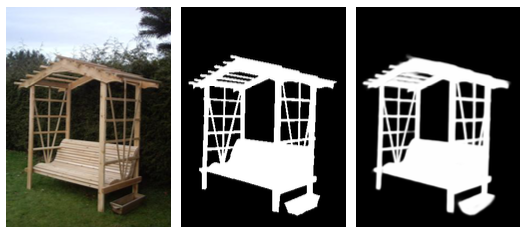

左から入力画像、真値、U<sup>2</sup>-Netによる推論結果<sup>1</sup>

## U<sup>2</sup>-Netとは
U<sup>2</sup>-Netは、2020年にPattern Recognitionで発表された論文において提唱されたモデルです。主な用途として、画像中の主要な・顕在的なオブジェクト（salient object）の検出に利用することができます。公式レポジトリ<sup>2</sup>はApache 2.0ライセンスで公開されており、

様々なサードパーティ製アプリ

このモデルを使用して、U2-Netを基にした多くの興味深いアプリケーションやツールが開発されています。例えば、人間の肖像画の描画、画像マッティングなどのアプリケーション、また、U2-Netを利用した画像の背景削除ツール（Rembg）などがあります​

## 一般シーンからの物体領域分割をするモデルを植物ドメインに適用する。



- <sup>1</sup>U2-Net: Going Deeper with Nested U-Structure for Salient Object Detection, Qin et al., Pattern Recognition 2022.

- <sup>2</sup>https://github.com/xuebinqin/U-2-Net
